In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

#for plots
def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.xaxis.set_tick_params(size=6)
    ax.yaxis.set_tick_params(size=6)

colors=['#F5A21E', '#02A68E', '#EF3E34', '#134B64', '#FF07CD']



In [4]:
import scipy.io
math = scipy.io.loadmat('../data/s1_ari_proc.mat')

### 1.1 Covariates

In [5]:
data = pd.DataFrame()
data['time'] =  math['time'][0]
data['handPos_x'] =  math['handPos'][0] - np.mean(math['handPos'][0])
data['handPos_y'] =  math['handPos'][1] - np.mean(math['handPos'][1])
data['handVel_x'] =  math['handVel'][0]
data['handVel_y'] =  math['handVel'][1]
data['handAcc_x'] =  math['handAcc'][0]
data['handAcc_y'] =  math['handAcc'][1]
data.head() 

,time,handPos_x,handPos_y,handVel_x,handVel_y,handAcc_x,handAcc_y
0,1.17,-0.161031,0.874437,0.151037,0.150912,0.495429,0.545026
1,1.22,-0.160162,0.881708,-0.139498,0.110064,-4.584201,-5.705682
2,1.27,-0.172404,0.874037,-0.355774,-0.396433,-2.825068,-2.918046
3,1.32,-0.188853,0.856217,-0.243297,-0.276727,4.535535,6.446413
4,1.37,-0.194168,0.857506,0.026628,0.287959,0.261249,-0.374490


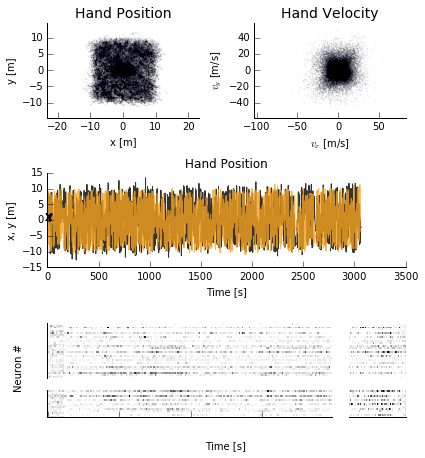

In [6]:
plt.figure(figsize=(6,6))
plt.rcParams['font.size'] = 10
plt.rcParams['font.weight'] = 'medium'
ldata = math['spikes'].shape

ts = 14
gs0 = gridspec.GridSpec(3, 2)
plt.subplot(gs0[0,0])
simpleaxis(plt.gca())
plt.scatter(data['handPos_x'], data['handPos_y'], s=.1, alpha=.1)

plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.axis('equal')
plt.title('Hand Position',fontsize=ts)
#plt.ylim([-0.42,-0.16])
#plt.xlim([-0.15,0.15])
#plt.xticks(np.arange(-0.15,0.2, .1))

plt.subplot(gs0[0,1])
simpleaxis(plt.gca())
plt.scatter(data['handVel_x'], data['handVel_y'], s=.1, alpha=.1)

plt.xlabel('$v_x$ [m/s]')
plt.ylabel('$v_y$ [m/s]')
plt.axis('equal')
plt.title('Hand Velocity',fontsize=ts)

plt.subplot(gs0[1,:])
a=plt.gca()
simpleaxis(a)
a.text(-20,-.03,'X',weight='bold')
a.text(-20,-.33,'Y',weight='bold')
alpha = 0.8
lw = 1
plt.plot(data['time'], data['handPos_x'], 'k-', alpha=alpha, lw=lw)
plt.plot(data['time'], data['handPos_y'], '-', color=colors[0], alpha=alpha, lw=lw)
#a.axis([-40,800,-0.5,0.1])

plt.xlabel('Time [s]')
plt.ylabel('x, y [m]')
plt.title('Hand Position')



gs00 = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs0[2,:], wspace = 0.1, hspace = 0.3,
                                        width_ratios=[5,1],height_ratios=[2,1])
plt.subplot(gs00[0,0])
plt.imshow(math['spikes'][1:30,1:200],aspect='auto',interpolation='none', cmap='Greys')
ax = plt.gca()
plt.text(-20, 15, 'Neuron #', ha='center', rotation = 'vertical')
simpleaxis(ax)
ax.spines['bottom'].set_visible(False)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)



plt.subplot(gs00[0,1])
plt.imshow(math['spikes'][1:30,ldata[1]-50:ldata[1]],aspect='auto',interpolation='none', cmap='Greys')
ax = plt.gca()
simpleaxis(ax)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.get_yaxis().set_ticks([])
ax.xaxis.set_visible(False)


plt.subplot(gs00[1,0])
plt.imshow(math['spikes'][ldata[0]-15:ldata[0],1:200],aspect='auto',interpolation='none', cmap='Greys')
ax = plt.gca()
plt.text(110,30, 'Time [s]', va='center')
simpleaxis(ax)
ax.yaxis.set_visible(False)
ax.get_xaxis().set_ticklabels([])

plt.subplot(gs00[1,1])
plt.imshow(math['spikes'][ldata[0]-15:ldata[0],ldata[1]-50:ldata[1]],aspect='auto',interpolation='none', cmap='Greys')
ax = plt.gca()
simpleaxis(ax)
ax.spines['left'].set_visible(False)
ax.get_yaxis().set_ticks([])
ax.xaxis.set_visible(False)


plt.tight_layout()

plt.savefig('../data_vis_s1.png', dpi=200, facecolor='w', edgecolor='w',
        orientation='portrait')

plt.show()


#### compute more covariates/features

In [7]:
data['velDir'] = np.arctan2(data['handVel_y'], data['handVel_x'])
data['cos_velDir'] = np.cos(data['velDir'])
data['sin_velDir'] = np.sin(data['velDir'])
data['speed'] = np.sqrt(data['handVel_x'].values**2+data['handVel_y'].values**2)
r = np.arctan2(data['handPos_y'], data['handPos_x'])
data['PosDir'] = r
data['cos_PosDir'] = np.cos(r)
data['sin_PosDir'] = np.sin(r)
data['radial_Pos'] = np.sqrt(data['handPos_x'].values**2+data['handPos_y'].values**2)
data.head()

,time,handPos_x,handPos_y,handVel_x,handVel_y,handAcc_x,handAcc_y,velDir,cos_velDir,sin_velDir,speed,PosDir,cos_PosDir,sin_PosDir,radial_Pos
0,1.17,-0.161031,0.874437,0.151037,0.150912,0.495429,0.545026,0.784984,0.707399,0.706814,0.213511,1.752910,-0.181109,0.983463,0.889141
1,1.22,-0.160162,0.881708,-0.139498,0.110064,-4.584201,-5.705682,2.473595,-0.785063,0.619415,0.177691,1.750487,-0.178725,0.983899,0.896137
2,1.27,-0.172404,0.874037,-0.355774,-0.396433,-2.825068,-2.918046,-2.302194,-0.667911,-0.744241,0.532667,1.765546,-0.193521,0.981096,0.890878
3,1.32,-0.188853,0.856217,-0.243297,-0.276727,4.535535,6.446413,-2.291999,-0.660288,-0.751012,0.368471,1.787887,-0.215389,0.976528,0.876797
4,1.37,-0.194168,0.857506,0.026628,0.287959,0.261249,-0.374490,1.478586,0.092079,0.995752,0.289188,1.793474,-0.220842,0.975310,0.879214


### 1.2 Neural data
#### Choose neuron

In [8]:
neuron_n = 1
y = math['spikes'][neuron_n-1]

#### check for position direction tuning and radial distance tuning

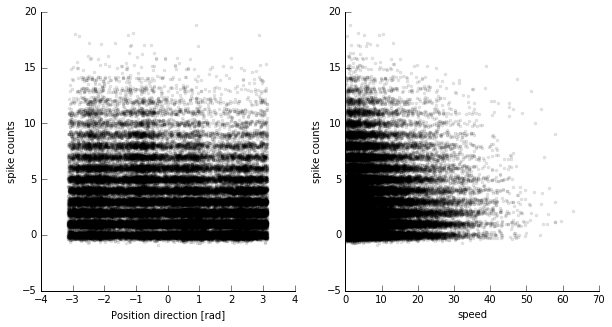

In [9]:
plt.figure(figsize=(10,5))

y_noise = np.random.randn(np.size(y))
nnoise = 0.2

plt.subplot(121)
simpleaxis(plt.gca())

plt.plot(data['PosDir'], y+nnoise*y_noise, 'k.', alpha=0.1)
plt.xlabel('Position direction [rad]')
plt.ylabel('spike counts')

plt.subplot(122)
simpleaxis(plt.gca())

plt.plot(data['speed'], y+nnoise*y_noise, 'k.', alpha=0.1)
plt.xlabel('speed')
plt.ylabel('spike counts')

plt.show()

Show the smoothed data, and the smoothed prediction, for each feature of interest.

In [10]:
import statsmodels.api as sm
lowess = sm.nonparametric.lowess


def plot_smoothed(features,y,Ythat):
    """Features is list of strings of feature names (in dataframe)"""
    l = len(features)
    plt.figure(figsize=(5*l,5))
    for i in range(l):
        plt.subplot(1,l,i+1)
        simpleaxis(plt.gca())
        feat = data[features[i]]
        delt = 0.001*(np.max(feat)-np.min(feat))
        plt.plot(feat, y+nnoise*y_noise, 'k.', alpha=0.1)
        plt.xlabel(features[i])
        plt.ylabel('spike counts')
        
        
        #smooth data
        smoothed = lowess(y,feat,return_sorted=True,frac=.05,delta = delt)
        plt.plot(smoothed[:,0],smoothed[:,1],color=colors[0],lw = 3)
        
        #smooth fit
        smoothed = lowess(Ythat,feat,return_sorted=True,frac=.05,delta=delt)
        plt.plot(smoothed[:,0],smoothed[:,1],color=colors[1],lw = 3)
    plt.tight_layout()
    plt.show()

        
        

# 2. GLM with poisson output

### using [pyglmnet](https://github.com/pavanramkumar/pyglmnet)
this is a python implementation of R's glmnet package

In [11]:
from pyglmnet import GLM

the firing rate is not linear on the movement angle, we need to do some feature engineering. More details [here](https://github.com/KordingLab/spykes/blob/master/notebooks_documentation/gradient_descent_tutorial.ipynb).

## Test GLM regularization

Why is it working so terribly? First let's look at the the pyglmnet implementation. (also: bayesian optimzation of a GLM in keras, later).

Test, neuron 8, a high firing, and neuron 15, a low firing

In [122]:
X_ = data.drop(['time','velDir','PosDir','handPos_x','handPos_y','handVel_x','handVel_y'], axis=1)
X_ = data[['handPos_x','handPos_y','handVel_x','handVel_y']]

X_.head()

,handPos_x,handPos_y,handVel_x,handVel_y
0,-0.161031,0.874437,0.151037,0.150912
1,-0.160162,0.881708,-0.139498,0.110064
2,-0.172404,0.874037,-0.355774,-0.396433
3,-0.188853,0.856217,-0.243297,-0.276727
4,-0.194168,0.857506,0.026628,0.287959


In [119]:
X = X_.values

## wtf
#X = np.ones((len(y),))

neuron_n = 8
y = math['spikes'][neuron_n]


# reg lambda = None defaults to path from 0.5 to 0.01
rl = None
rl = np.logspace(np.log(5), np.log(0.001), 10,base=np.exp(1))


def glm_pyglmnet(Xr, Yr, Xt):
    glm = GLM(distr='poisson', alpha=0.1, reg_lambda=10, tol=1e-3, #solver='cdfast',
       learning_rate=0.01, max_iter=10000, eta=4.0, random_state=1, verbose=False,
            )# score_metric = 'pseudo_R2')
    glm.fit(Xr, Yr)
    Yt = glm.predict(Xt)[0]
    
    print("\nMean y_test: "+str(np.mean(Yr))+"\n GLM thinks mean y: "+str(np.mean(glm.ynull_))+
      "\n exp(beta0) is "+str(np.exp(glm.fit_[0]['beta0'][0]))+"\n mean yhat is "+str(np.mean(Yt))+"\n" )

    return Yt

Yt_hat, PR2 = fit_cv(X, y, 'glm_keras', n_cv=4, verbose=2, label=[])


...runnning cv-fold 1 of 4


KeyboardInterrupt: 

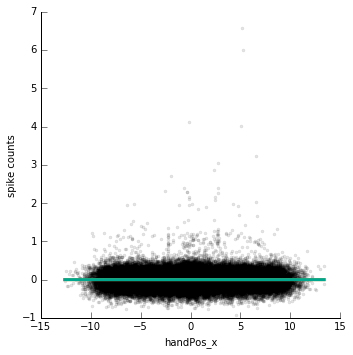

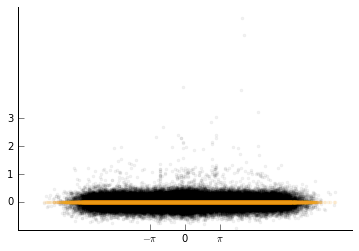

In [117]:
plot_smoothed(['handPos_x'],y,Yt_hat)

f= plt.figure()
ax2 = plt.gca()
plt.plot(data['handPos_x'], y+nnoise*y_noise, 'k.', alpha=0.05)
plt.plot(data['handPos_x'], Yt_hat, '.', c=colors[0], alpha=0.1)
ax2.set_xticks([-np.pi,0,np.pi])
ax2.set_yticks([0,1,2,3])
ax2.set_xticklabels(['$-\pi$','0','$\pi$'])
simpleaxis(plt.gca())

GLM pR2 as a function of firing rate. (though you'll need to get 'Models' first)

In [18]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.core import Lambda
from keras.regularizers import l1l2

def glm_keras(Xr, Yr, Xt,l1=0.8,l2=100):
    
    model = Sequential()
    model.add(Dense(1, input_dim=np.shape(Xr)[1], init='uniform',W_regularizer=l1l2(l1,l2), activation='linear'))
    model.add(Lambda(lambda x: np.exp(x)))
    model.compile(loss='poisson', optimizer='rmsprop')

    model.fit(Xr, Yr, nb_epoch=4, verbose=0, validation_split=0.0)
    
    Yt = model.predict_proba(Xt, verbose=0)
    
    return Yt[:,0]

Using Theano backend.


### Trying R's pyglmnet

In [101]:
import rpy2.robjects as ro
import rpy2.robjects.numpy2ri as n2r
n2r.activate()

r = ro.r
r.library('glmnet')

# def r_glmnet_cv(Xr,Yr,Xt):
#     yr = ro.FloatVector(Yr) # use factors
#     trained_model = r['cv.glmnet'](Xr, yr, family="poisson")
#     lambda_min = np.asanyarray(trained_model.rx2('lambda.min'))[0]
#     Yt = r['predict'](trained_model,s=lambda_min,newx=Xt,type="response")
#     return np.array(list(Yt))

def r_glmnet(Xr,Yr,Xt):
    yr = ro.FloatVector(Yr) # use factors
    trained_model = r['glmnet'](Xr, yr, family="poisson",alpha = 0.1)
    lambda_min = np.asanyarray(trained_model.rx2('lambda'))[-1]
    Yt = r['predict'](trained_model,s=lambda_min,newx=Xt,type="response")
    return np.array(list(Yt))

In [103]:
X = X_.values

neuron_n = 8
y = math['spikes'][neuron_n]

Yt_hat, PR2 = fit_cv(X, y, 'r_glmnet', n_cv=4, verbose=2, label=[])


...runnning cv-fold 1 of 4
pR2:  0.000816754782785
...runnning cv-fold 2 of 4
pR2:  0.000636549713039
...runnning cv-fold 3 of 4
pR2:  0.00128916720165
...runnning cv-fold 4 of 4
pR2:  0.000870984589227
pR2_cv: 0.000903 (+/- 0.000120)
Mean y: 0.879214215846, mean yhat: 0.879137023226


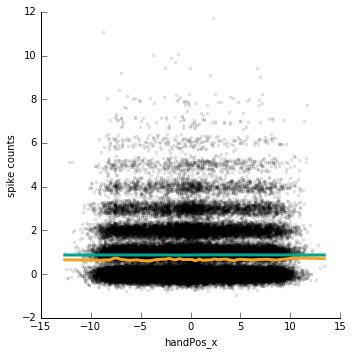

In [104]:
plot_smoothed(['handPos_x'],y,Yt_hat)

Seems to be working!! 

Let's try to run pyglmnet with the same regularization path...

In [123]:
neuron_n = 8
y = math['spikes'][neuron_n]
X = X_.values

def py_Rpath(Xr, Yr, Xt):
    #get path from glmnet
    yr = ro.FloatVector(Yr) 
    trained_model = r['glmnet'](Xr, yr, family="poisson",alpha = 0.1)
    path = np.asanyarray(trained_model.rx2('lambda'))
    
    #run with pyglmnet
    glm = GLM(distr='poisson', alpha=0.1, reg_lambda=path, tol=1e-3, )
    glm.fit(Xr, Yr)
    Yt = glm.predict(Xt)[0]
    
    print("\nMean y_test: "+str(np.mean(Yr))+"\n GLM thinks mean y: "+str(np.mean(glm.ynull_))+
      "\n exp(beta0) is "+str(np.exp(glm.fit_[0]['beta0'][0]))+"\n mean yhat is "+str(np.mean(Yt))+"\n" )

    return Yt

Yt_hat, PR2 = fit_cv(X, y, 'py_Rpath', n_cv=4, verbose=2, label=[])


...runnning cv-fold 1 of 4

Mean y_test: 0.885599391371
 GLM thinks mean y: 0.885599391371
 exp(beta0) is 0.000411927287626
 mean yhat is 6.24597208743

pR2:  -17.4722837027
...runnning cv-fold 2 of 4

Mean y_test: 0.879860884686
 GLM thinks mean y: 0.879860884686
 exp(beta0) is 0.000364188044748
 mean yhat is 7.88373870267

pR2:  -19.783277945
...runnning cv-fold 3 of 4

Mean y_test: 0.875361373764
 GLM thinks mean y: 0.875361373764
 exp(beta0) is 0.000395012851324
 mean yhat is 6.3544866013

pR2:  -17.5911084074
...runnning cv-fold 4 of 4

Mean y_test: 0.876035213564
 GLM thinks mean y: 0.876035213564
 exp(beta0) is 0.000424705830824
 mean yhat is 6.57127053531

pR2:  -17.7521136318
pR2_cv: -18.149696 (+/- 0.474181)
Mean y: 0.879214215846, mean yhat: 6.76386698168


# 3. Cross-validation
because...

#### first define some functions

In [15]:
from sklearn.cross_validation import KFold
from sklearn.cross_validation import LabelKFold

# def glm_pyglmnet(Xr, Yr, Xt):
#     glm = GLM(distr='poisson', alpha=0., reg_lambda=[0.], tol=1e-6)
#     glm.fit(Xr, Yr)
#     Yt = glm.predict(Xt)[0]
#     return Yt

def poisson_pseudoR2(y, yhat, ynull):
    yhat = yhat.reshape(y.shape)
    
    eps = np.spacing(1)
    L1 = np.sum(y*np.log(eps+yhat) - yhat)
    L1_v = y*np.log(eps+yhat) - yhat
    L0 = np.sum(y*np.log(eps+ynull) - ynull)
    LS = np.sum(y*np.log(eps+y) - y)
    R2 = 1-(LS-L1)/(LS-L0)
    return R2

def fit_cv(X, Y, algorithm = 'glm_pyglmnet', n_cv=10, verbose=1, label=[],func=None):

    if np.ndim(X)==1:
        X = np.transpose(np.atleast_2d(X))

    if len(label)>0:
        skf  = LabelKFold(np.squeeze(label), n_folds=n_cv)
    else:
        skf  = KFold(n=np.size(Y), n_folds=n_cv, shuffle=True, random_state=42)

    i=1
    Y_hat=np.zeros(len(Y))
    pR2_cv = list()
    for idx_r, idx_t in skf:
        if verbose > 1:
            print( '...runnning cv-fold', i, 'of', n_cv)
        i+=1
        Xr = X[idx_r, :]
        Yr = Y[idx_r]
        Xt = X[idx_t, :]
        Yt = Y[idx_t]

        if func:
            Yt_hat = func(Xr, Yr, Xt)
        else:
            Yt_hat = eval(algorithm)(Xr, Yr, Xt)
        Y_hat[idx_t] = Yt_hat

        pR2 = poisson_pseudoR2(Yt, Yt_hat, np.mean(Yr))
        pR2_cv.append(pR2)

        if verbose > 1:
            print( 'pR2: ', pR2)

    if verbose > 0:
        print("pR2_cv: %0.6f (+/- %0.6f)" % (np.mean(pR2_cv),
                                             np.std(pR2_cv)/np.sqrt(n_cv)))
        print("Mean y: "+str(np.mean(Y))+", mean yhat: "+str(np.mean(Y_hat)))
        

    
    return Y_hat, pR2_cv

def plot_model_comparison(models_for_plot, models=[], color='r', title=None, labels=[],fs=12):

    plt.plot([-1, len(models_for_plot)], [0,0],'--k', alpha=0.4)
    
    if not labels: 
        labels = models_for_plot

    mean_pR2 = list()
    sem_pR2 = list()

    for model in models_for_plot:
        PR2_art = models[model]['PR2']
        mean_pR2.append(np.mean(PR2_art))
        sem_pR2.append(np.std(PR2_art)/np.sqrt(np.size(PR2_art)))

    plt.bar(np.arange(np.size(mean_pR2)), mean_pR2, 0.8, align='center',
            ecolor='k', alpha=.9, color=color, ec='w', yerr=np.array(sem_pR2),
            tick_label=labels)
    plt.plot(np.arange(np.size(mean_pR2)), mean_pR2, 'k.', markersize=15)

    plt.ylabel('Pseudo-R2',fontsize=fs)
    simpleaxis(plt.gca())
    if title:
        plt.title(title)

//anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


#### Get GLM scores for all neurons with R glmnet.

Use both sets of features, figure out which is better

In [ ]:
X = data[['handPos_x','handPos_y','handVel_x','handVel_y']].values
start = 0


if not start:
    Models = dict()
    Models['glm_all_pop'] = dict()
    Models['glm_all_pop']['PR2']  = list()
    Models['glm_all_pop']['Yt_hat']  = list()
    Models['glm_all_pop_2'] = dict()
    Models['glm_all_pop_2']['PR2']  = list()
    Models['glm_all_pop_2']['Yt_hat']  = list()

nneurons = np.shape(math['spikes'])[0]
for i in range(start,nneurons):
    print '\n running for neuron %d' % i
    y = math['spikes'][i]

    Yt_hat, PR2 = fit_cv(X, y, algorithm = 'r_glmnet', n_cv=8, verbose=1, label=[])

    try:
        Models['glm_all_pop']['PR2'][i]=PR2
        Models['glm_all_pop']['Yt_hat'][i]=Yt_hat
    except IndexError:
        Models['glm_all_pop']['PR2'].append(PR2)
        Models['glm_all_pop']['Yt_hat'].append(Yt_hat)
        
        
X = data.drop(['time','velDir','PosDir','handPos_x','handPos_y','handVel_x','handVel_y'], axis=1).values
for i in range(start,nneurons):
    print '\n running for neuron %d' % i
    y = math['spikes'][i]

    Yt_hat, PR2 = fit_cv(X, y, algorithm = 'r_glmnet', n_cv=8, verbose=1, label=[])

    try:
        Models['glm_all_pop_2']['PR2'][i]=PR2
        Models['glm_all_pop_2']['Yt_hat'][i]=Yt_hat
    except IndexError:
        Models['glm_all_pop_2']['PR2'].append(PR2)
        Models['glm_all_pop_2']['Yt_hat'].append(Yt_hat)
        
